## Follow the instructions of this notebook to create all relevant directories and to load all relevant data into the correct places

### Import packages and set up paths

In [1]:
import ast
import os, sys
import pymongo as pm
import pandas as pd
import socket
import json
import numpy as np
import base64
import importlib
import time
from collections import Counter
from PIL import Image
from io import BytesIO
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import mode
from scipy.spatial.distance import pdist, squareform

import utils

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

F:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [105]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
ratings_dir = os.path.join(plot_dir,'ratings')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
gallery_dir = os.path.abspath(os.path.join(proj_dir,'gallery'))
if socket.gethostname() == 'nightingale':
    feature_dir = os.path.abspath('/mnt/pentagon/photodraw/features/')
else:
    feature_dir = os.path.abspath(os.path.join(proj_dir,'features'))
stims_gallery_dir = os.path.join(gallery_dir, 'stims')
    
meta_path = os.path.abspath(os.path.join(feature_dir, 'metadata_pixels.csv'))
image_path = os.path.abspath(os.path.join(feature_dir, 'flattened_sketches_pixels.npy'))
meta_path_fc6 = os.path.abspath(os.path.join(feature_dir, 'METADATA_sketch.csv'))
image_path_fc6 = os.path.abspath(os.path.join(feature_dir, 'FEATURES_FC6_sketch_no-channel-norm.npy'))

## add helpers to python path
if os.path.join(proj_dir,'utils') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'utils'))   

def make_dir_if_not_exists(dir_name):   
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return dir_name

## create directories that don't already exist        
result = [make_dir_if_not_exists(x) for x in [results_dir,plot_dir,csv_dir,
                                              sketch_dir,gallery_dir,feature_dir, 
                                              ratings_dir,stims_gallery_dir]]

### establish connection to mongo

`ssh -fNL 27020:127.0.0.1:27017 jyang@cogtoolslab.org`  
`ssh -fNL 27017:127.0.0.1:27017 jyang@cogtoolslab.org`

In [3]:
# set vars 

# this auth.txt file contains the password for the sketchloop user
auth = pd.read_csv(os.path.join(analysis_dir,'auth.txt'), header = None) 
pswd = auth.values[0][0]
decoderpswd = int(pswd[-1])
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import socket
if socket.gethostname().split('_')[0]=='Justin':
    conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27020')
else:
    conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1:27017')
db = conn['photodraw']
coll = db['sketchy32']

iterationName = 'livetest0'
coll.distinct('iterationName')

# get a sample: coll.find_one({'iterationName':iterationName})

['development', 'friendtest', 'livetest0', 'livetest1']

### clean data

In [4]:
K_responses = coll.find({
            'iterationName':'livetest1', 
            'prolificID': {'$exists' : True},
            'studyID': {'$exists' : True},
            'sessionID': {'$exists' : True},
            'eventType': 'rating-task'
})
K_responses = pd.DataFrame(K_responses)

K_flags = coll.find({
            'iterationName': 'livetest1',
            'prolificID': {'$exists' : True},
            'studyID': {'$exists' : True},
            'sessionID': {'$exists' : True},
            'eventType': 'trial-catches'
})
K_flags = pd.DataFrame(K_flags)

# remove those who never completed the experiment
dropped_out = set(K_responses.prolificID.unique()).difference(set(K_flags.prolificID.unique()))
K_responses = K_responses[~K_responses.prolificID.isin(dropped_out)]

# make map from prolificID to flags and use map to extend to K_responses
id_to_flags = dict(zip(K_flags['prolificID'].values, K_flags[['failed_catches', 'num_failed','lazy_responder','repeat_offender']].values.tolist()))

df1 = K_responses['prolificID'].map(id_to_flags)
df1 = pd.DataFrame(df1.tolist(), df1.index, columns = ['failed_catches', 'num_failed','lazy_responder','repeat_offender'])

K_responses = pd.concat([K_responses, df1], axis=1)

In [5]:
# reformat the response data to only include values from ['Not At All', ..., 'Extremely']
value_list = [json.loads(dic)['typicality'] for dic in K_responses.responses.values]
K_responses = K_responses.assign(ratings = value_list)

# drop unneccesary columns and drop empty ratings
K_responses = K_responses.drop(columns=['devMode', 'preamble', 'required', 'questions', 
                                        'randomize_question_order', 'scale_width', 'button_label', 'responses',
                                        'question_order', 'trial_type', 'internal_node_id'])
K_responses['ratings'] = K_responses['ratings'].replace('', np.nan)
K_responses = K_responses.dropna(subset=['ratings'])

di = {"Not At All": -2, "Somewhat": -1, "Moderately": 0, "Very": 1, "Extremely": 2}
K_responses['enumerated_ratings'] = K_responses['ratings'].map(lambda x: di[x])

# if a participant has more than 136 trials, find the gameID which has 136 entries and just use the trials from that gameID
for pid in K_responses.prolificID.unique():
    if K_responses[K_responses.prolificID == pid].shape[0] != 136:
        subset = K_responses[K_responses.prolificID == pid]
        for gid in subset.gameID.unique():
            if subset[subset.gameID == gid].shape[0] == 136:
                K_responses = K_responses[K_responses.prolificID != pid].append(subset[subset.gameID == gid], 
                                                                                ignore_index = True)

# merge catch trial and main trial URLs
K_responses = K_responses.sort_values('img_id')
K_responses['img_id'] = K_responses['img_id'].fillna(K_responses['img_url'])
K_responses = K_responses.reset_index(drop=True).drop(columns=['img_url'])

In [6]:
# some trials (batch 0) were encoding the 'enumerated ratings' values wrong. this code fixes it

catch_trials = {'stimuli/catch_trials/0_ford_truck.jpg':[1,2], 'stimuli/catch_trials/1_german_shepherd.jpg':[1,2], 
                'stimuli/catch_trials/2_oddtruck.jpg':[-2,-1], 'stimuli/catch_trials/3_bedlington_terrier.jpg':[-2,-1], 
                'stimuli/catch_trials/4_pickup_truck.jpg':[1,2], 'stimuli/catch_trials/5_wierd_dog.jpg':[-2,-1], 
                'stimuli/catch_trials/6_wierdtruck.jpg':[-2,-1], 'stimuli/catch_trials/7_golden_retriever.jpg':[1,2]}
for i in K_responses.prolificID.unique():
    ppt_sub = K_responses[K_responses.prolificID == i]
    counter = 0
    for key, values in catch_trials.items():
        if ppt_sub[ppt_sub.img_id == key]['enumerated_ratings'].values[0] not in values:
            counter += 1
    K_responses.loc[(K_responses.prolificID == i), 'num_failed'] = counter
    if counter >= 4:
        K_responses.loc[(K_responses.prolificID == i), 'failed_catches'] = True
    else:
        K_responses.loc[(K_responses.prolificID == i), 'failed_catches'] = False
x=K_responses.groupby('prolificID')[['num_failed', 'failed_catches', 'repeat_offender']].mean()
# drop participants who failed either catch trials or repeat_offender
K_responses = K_responses[(K_responses.failed_catches == False) & (K_responses.repeat_offender == False)]
K_responses.shape, int(K_responses.shape[0]/136)

((11968, 22), 88)

In [7]:
# generate a dictionary with key: prolificID, value: subset of K_responses corresponding to that prolificID
b = {k: v for (k, v) in K_responses.groupby('prolificID')}
keys = list(b.keys())

# get just the enumerated ratings in the form of a 2D numpy array
list_ = []
for i in keys:
    list_.append(b[i].enumerated_ratings.values)
participant_ratings = np.stack(list_, axis=0)

corr_ratings = pd.DataFrame(data = np.corrcoef(participant_ratings), columns = keys, index = keys)
euc_ratings = pd.DataFrame(squareform(pdist(participant_ratings,metric='euclidean')),columns=keys,index=keys)
cos_ratings = pd.DataFrame(squareform(pdist(participant_ratings,metric='cosine')),columns=keys,index=keys)
corr_vals = corr_ratings.mean().values
euc_values = euc_ratings.mean().values
cos_values = cos_ratings.mean().values

corr_vals_adj = np.abs(corr_vals - np.median(corr_vals))/(1/len(corr_vals)*sum(np.abs(corr_vals - np.mean(corr_vals))))
euc_values_adj = np.abs(euc_values - np.median(euc_values))/(1/len(euc_values)*sum(np.abs(euc_values - np.mean(euc_values))))
cos_values_adj = np.abs(cos_values - np.median(cos_values))/(1/len(cos_values)*sum(np.abs(cos_values - np.mean(cos_values))))

In [8]:
# drop values whose adjusted correlation z-scores are greater than 3 on any of the three distance/correlation metrics
tooDissimilar = dict(zip(corr_ratings.mean().index.values, 
                        (corr_vals_adj >= 3) | (euc_values_adj >= 3) | (cos_values_adj >= 3)))
K_responses['tooDissimilar'] = K_responses['prolificID'].map(tooDissimilar)
K_responses = K_responses[K_responses.tooDissimilar == False]
K_responses.shape, int(K_responses.shape[0]/136)

((10880, 23), 80)

In [9]:
K_responses.groupby('batch_num')['prolificID'].nunique()

batch_num
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
Name: prolificID, dtype: int64

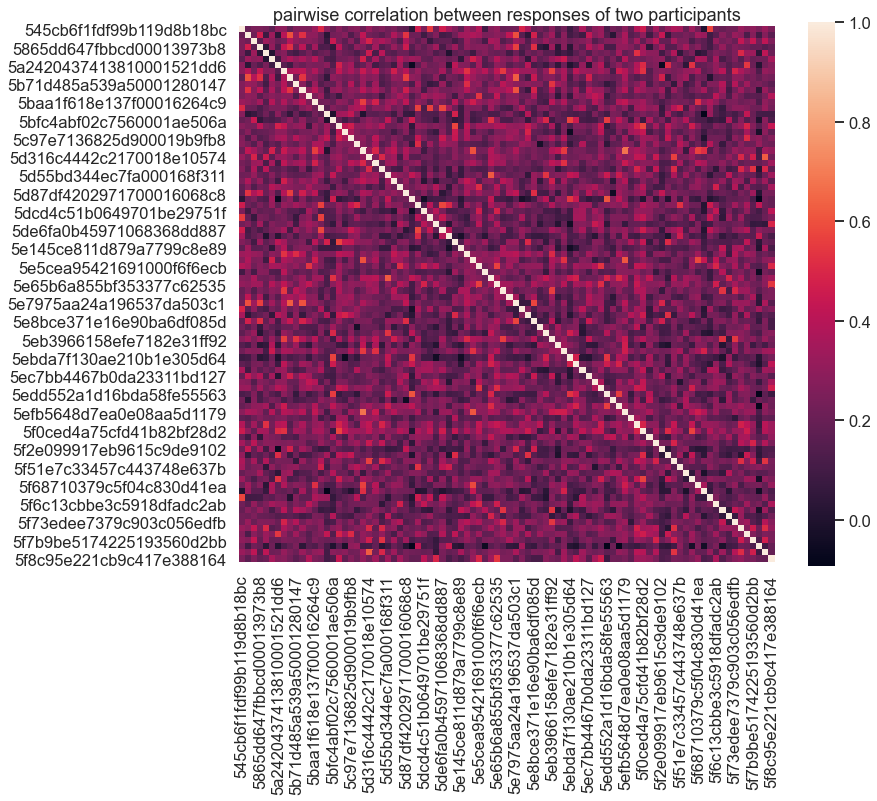

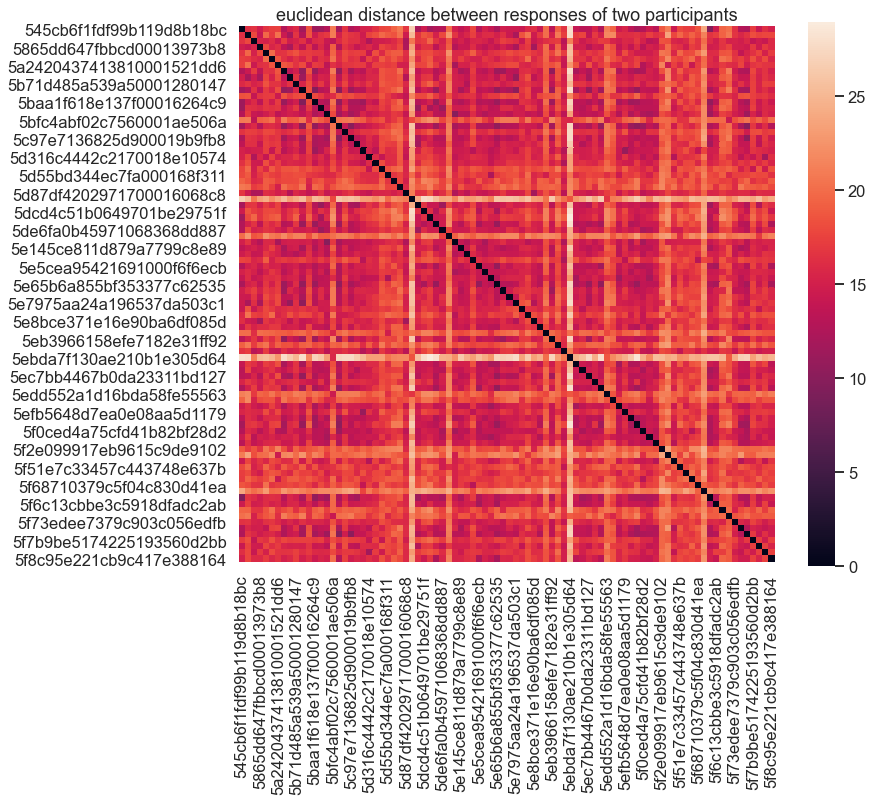

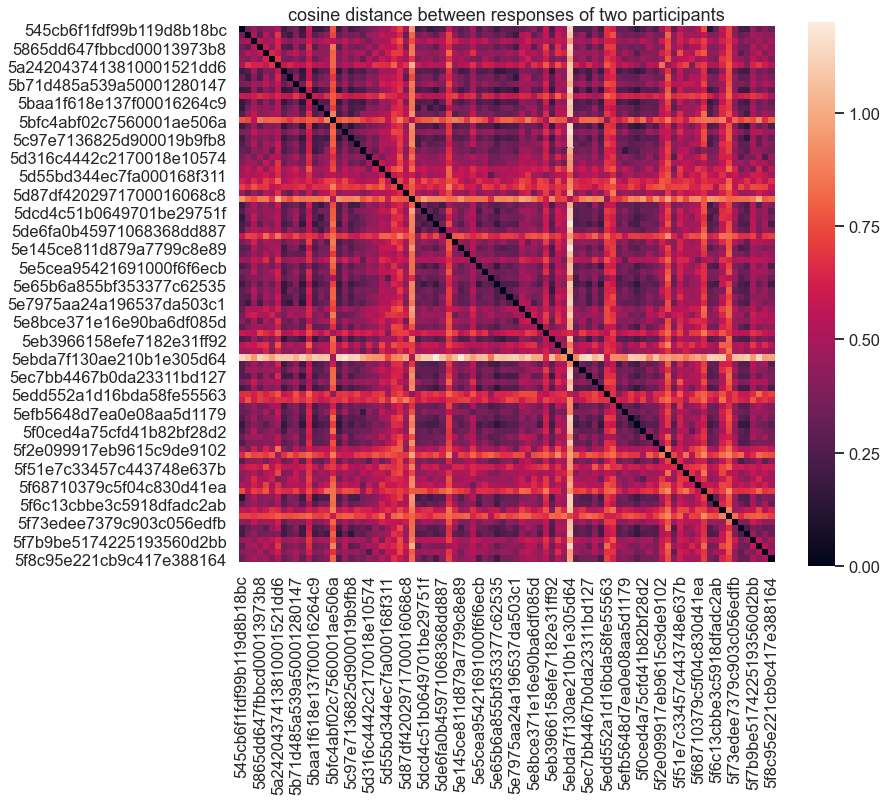

In [10]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_ratings, square=True)
plt.title('pairwise correlation between responses of two participants');
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(euc_ratings, square=True);
plt.title('euclidean distance between responses of two participants');
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(cos_ratings, square=True);
plt.title('cosine distance between responses of two participants');
plt.show();

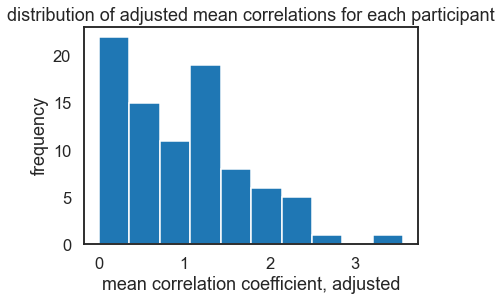

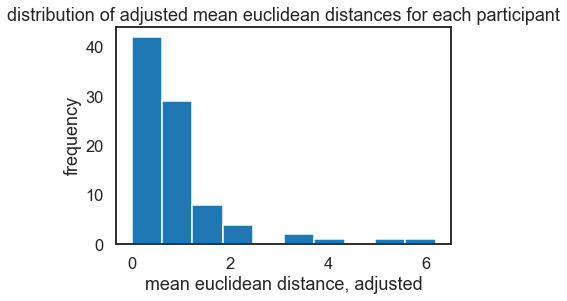

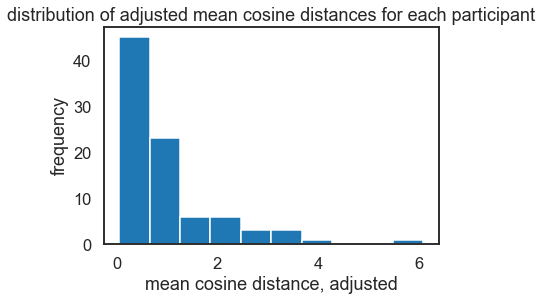

In [11]:
plt.hist(corr_vals_adj)
plt.xlabel('mean correlation coefficient, adjusted')
plt.ylabel('frequency')
plt.title('distribution of adjusted mean correlations for each participant');
plt.show()

plt.hist(euc_values_adj)
plt.xlabel('mean euclidean distance, adjusted')
plt.ylabel('frequency')
plt.title('distribution of adjusted mean euclidean distances for each participant');
plt.show()

plt.hist(cos_values_adj)
plt.xlabel('mean cosine distance, adjusted')
plt.ylabel('frequency')
plt.title('distribution of adjusted mean cosine distances for each participant');
plt.show();

### How does the distribution of the norming data look?

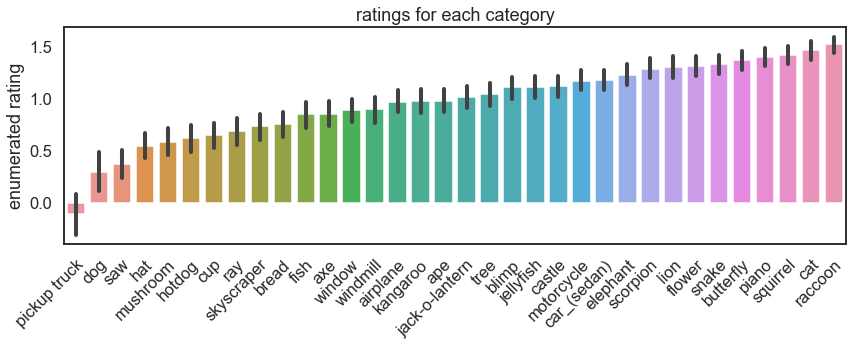

In [12]:
fig, ax = plt.subplots(figsize=(14,4)) 

sns.barplot(data=K_responses, 
            x='category', 
            y='enumerated_ratings', 
            order=K_responses.groupby('category').mean().sort_values('enumerated_ratings').index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor");
plt.xlabel('')
plt.ylabel('enumerated rating')
plt.title('ratings for each category');

In [13]:
K_responses.groupby('category').mean().sort_values('enumerated_ratings').index.values[0+2:16+2]

array(['saw', 'hat', 'mushroom', 'hotdog', 'cup', 'ray', 'skyscraper',
       'bread', 'fish', 'axe', 'window', 'windmill', 'airplane',
       'kangaroo', 'ape', 'jack-o-lantern'], dtype=object)

In [14]:
K_responses.groupby('category').mean().sort_values('enumerated_ratings').index.values[16+2:]

array(['tree', 'blimp', 'jellyfish', 'castle', 'motorcycle',
       'car_(sedan)', 'elephant', 'scorpion', 'lion', 'flower', 'snake',
       'butterfly', 'piano', 'squirrel', 'cat', 'raccoon'], dtype=object)

In [15]:
order = ["Not At All", "Somewhat", "Moderately", "Very", "Extremely"]

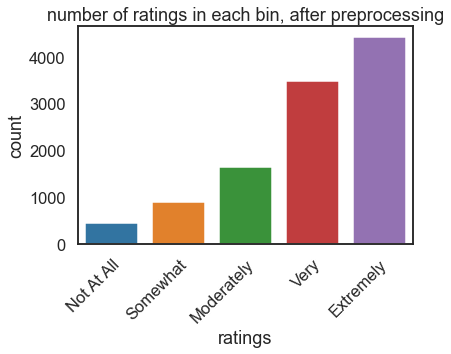

In [16]:
fig, ax = plt.subplots(figsize=(6,4)) 

sns.countplot(data=K_responses, x='ratings', order=order)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor");
plt.title('number of ratings in each bin, after preprocessing');

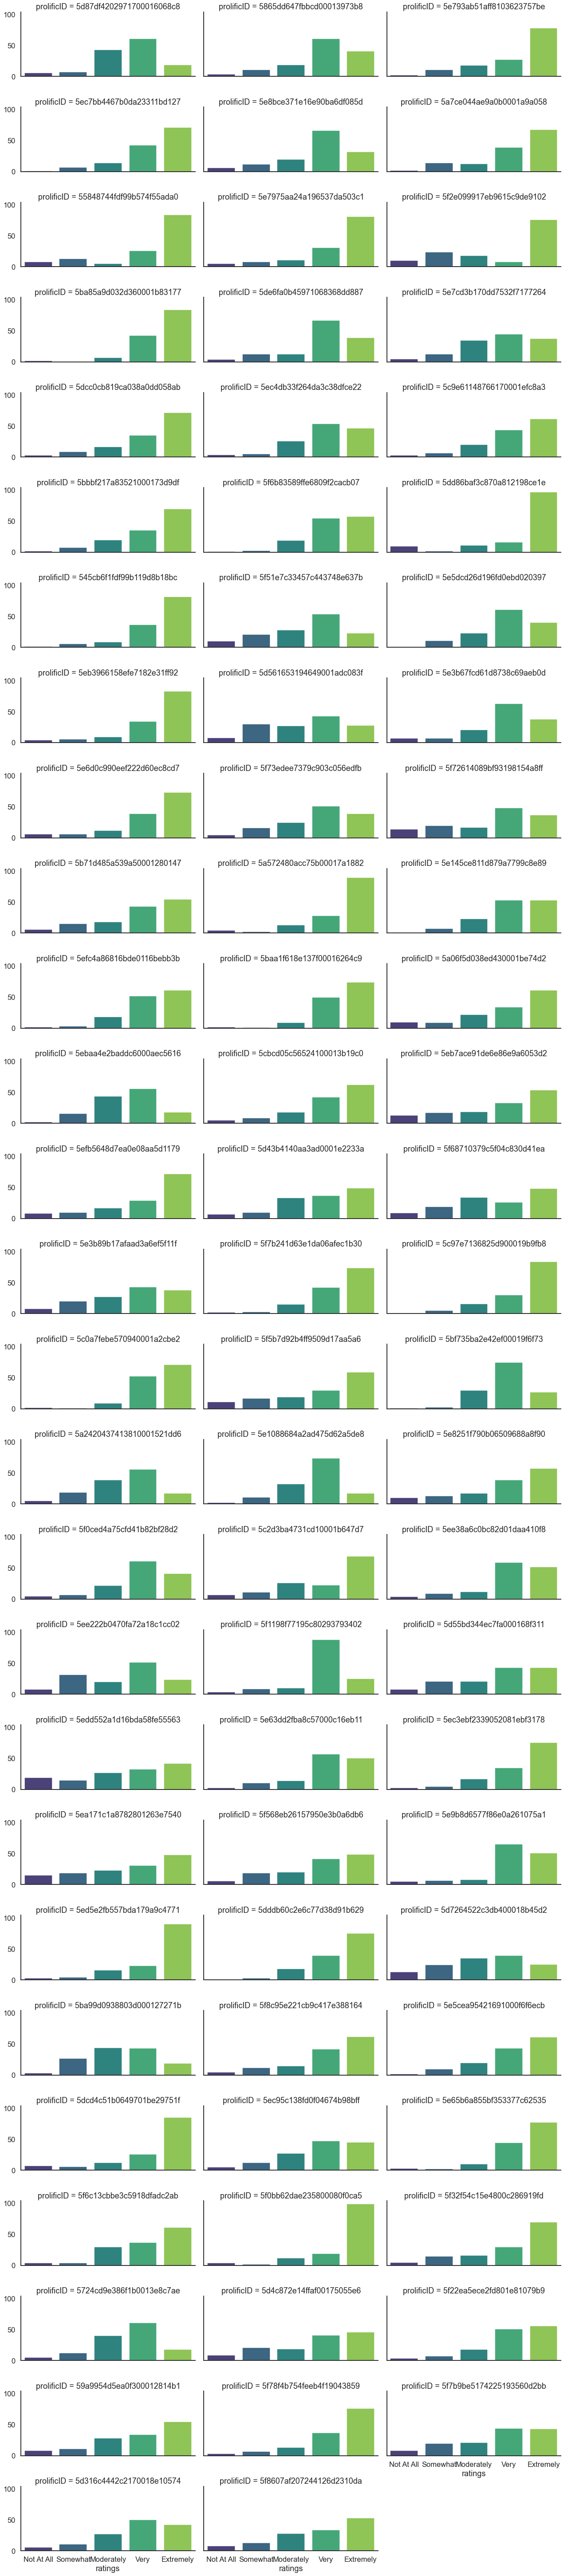

In [17]:
g = sns.FacetGrid(K_responses, col='prolificID', col_wrap=3, aspect=2)
g.map(sns.countplot, "ratings", order=order, palette='viridis');

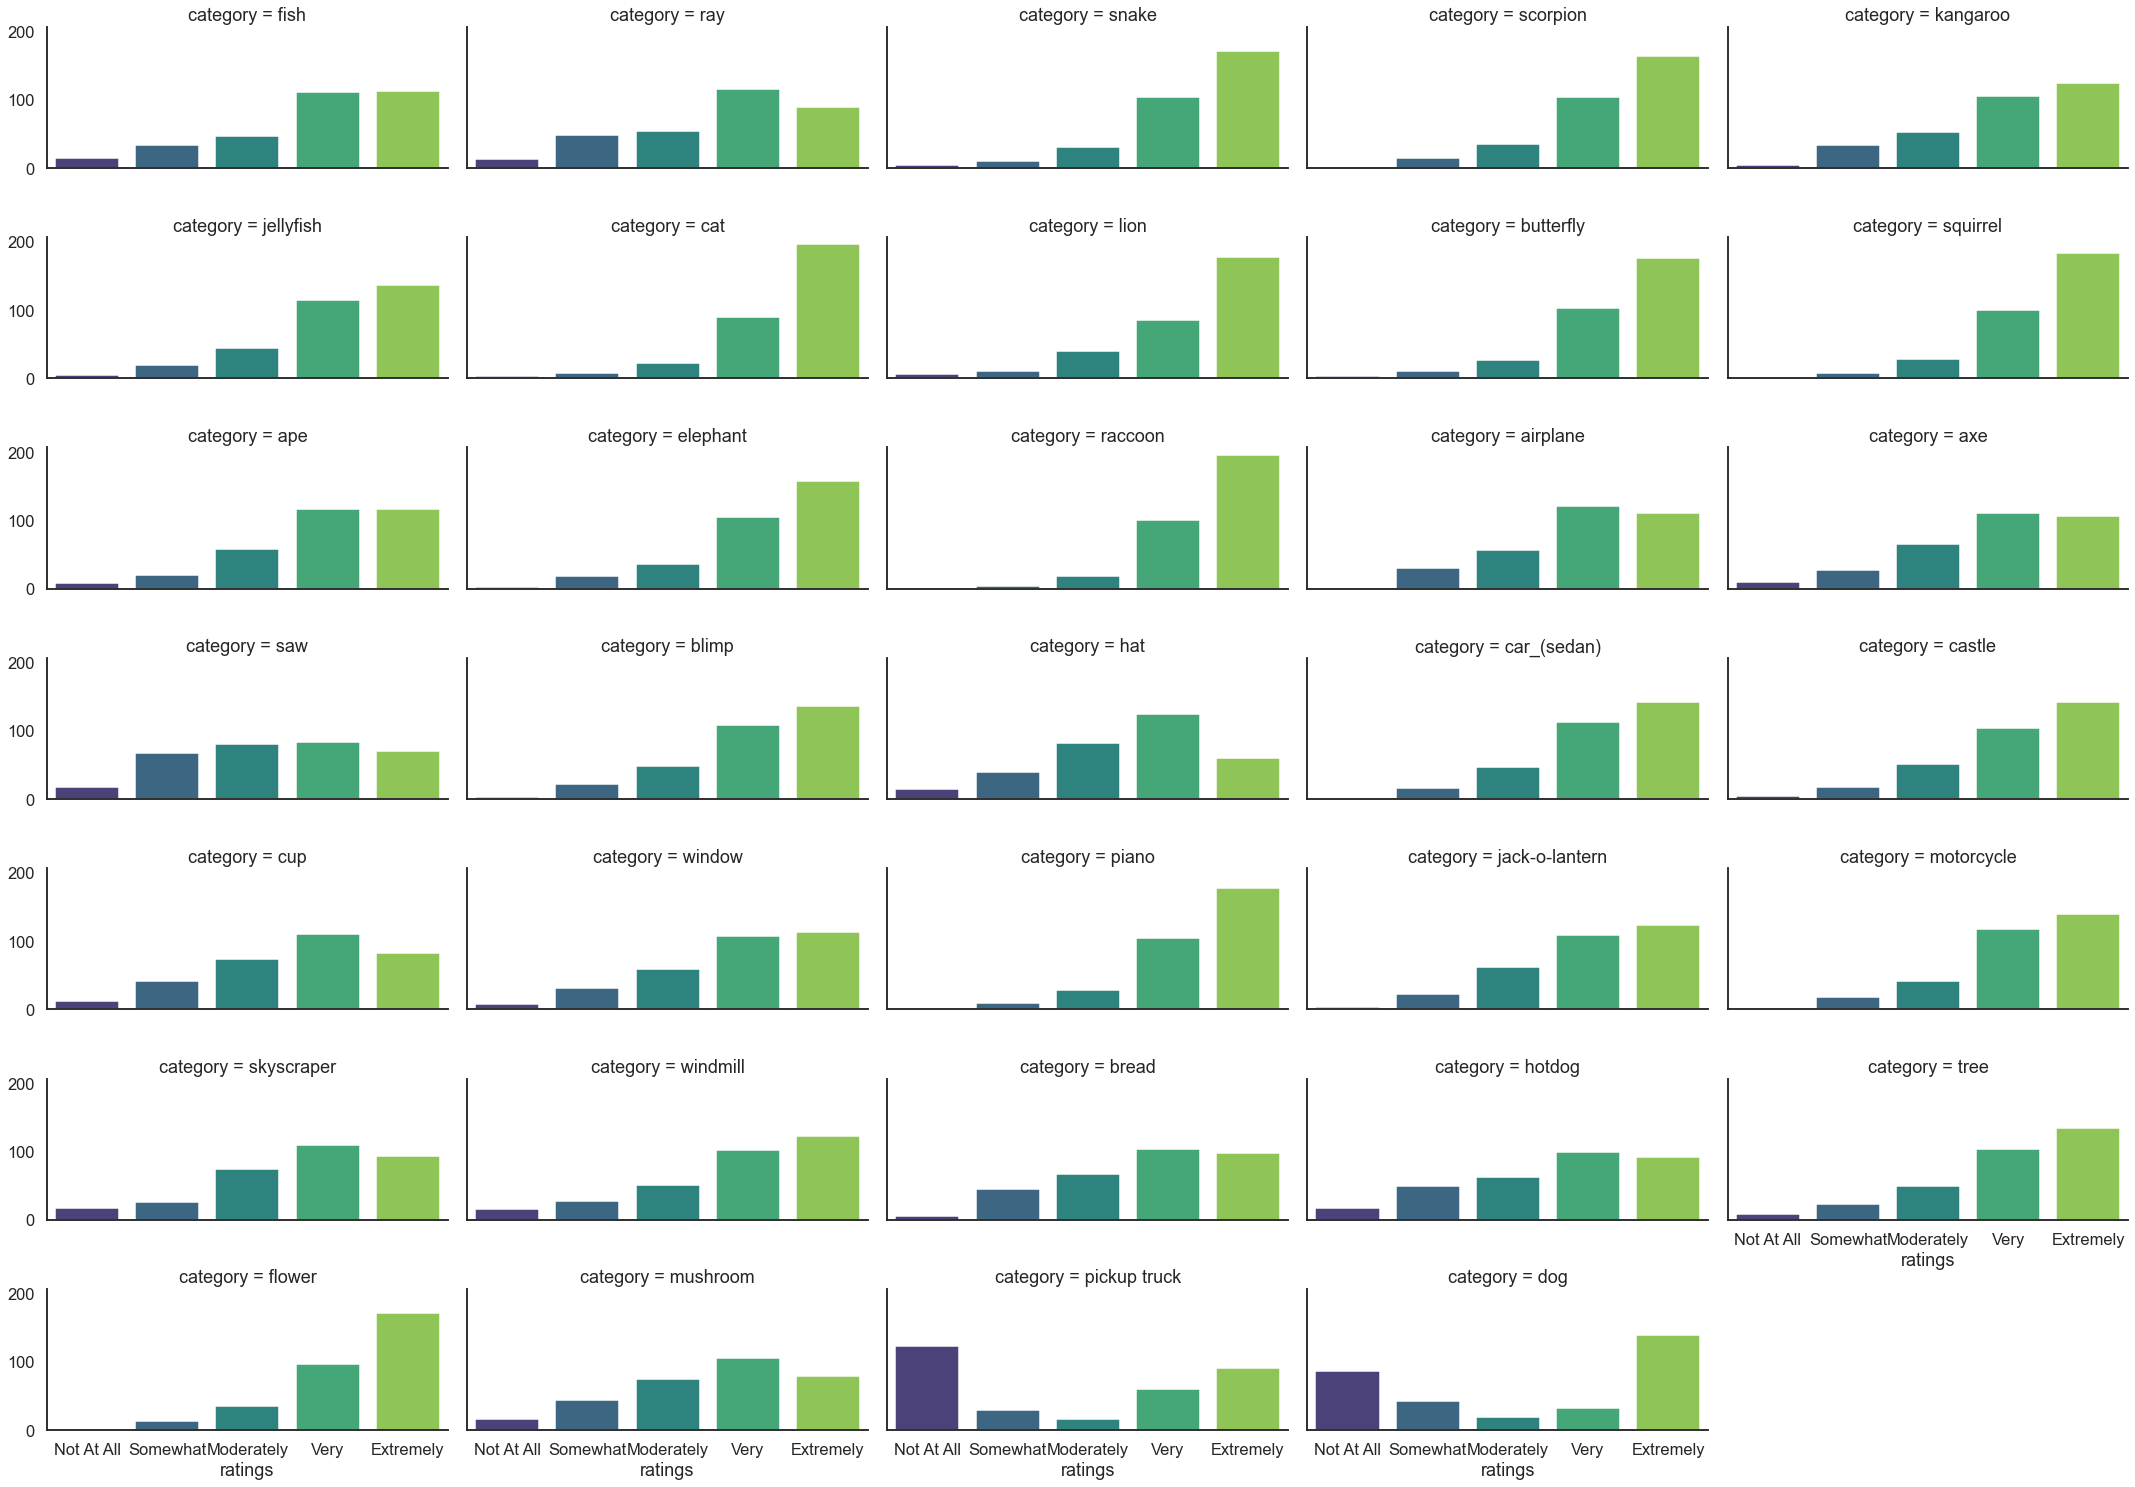

In [18]:
g = sns.FacetGrid(K_responses, col='category', col_wrap=5, aspect=2)
g.map(sns.countplot, "ratings", order=order, palette='viridis');

In [49]:
K_responses.groupby('batch_num')['prolificID'].nunique()

batch_num
0    10
1    10
2    10
3    10
4    10
5    10
6    10
7    10
Name: prolificID, dtype: int64

<br><br>


In [50]:
# plot and save count plots for each category
# note: does not divide the graph into 3x3 segments!

from pylab import MaxNLocator

#randcat = np.random.choice(K_responses.category.unique())
for cat in K_responses.category.unique():
    instdf = K_responses[K_responses.category == cat][['img_id', 'enumerated_ratings']].sort_values('enumerated_ratings')

    gb_df = instdf.groupby(["img_id", "enumerated_ratings"]).size().reset_index(name = "counts")
    gb_df.sort_values(["img_id", "enumerated_ratings", "counts"], ascending = True, inplace = True)
    order = K_responses[K_responses.category == cat
                       ].groupby('img_id')['enumerated_ratings'].mean().sort_values(ascending=False).index.values
    colors = {i:np.random.random(3,) for i in order}


    fig = plt.figure(figsize = (12, 6))
    ax = fig.add_subplot()

    for x in order:

        # get x and y values for each group
        x_values = gb_df[gb_df["img_id"] == x]["img_id"]
        y_values = gb_df[gb_df["img_id"] == x]["enumerated_ratings"]

        # extract the size of each group to plot
        size = gb_df[gb_df["img_id"] == x]["counts"]

        # extract the color for each group and covert it from rgb to hex
        color = matplotlib.colors.rgb2hex(colors[x])

        # plot the data
        ax.scatter(x_values, y_values, s = size*50, alpha=1, cmap = colors)
    ax.set_title("Count plot: " + cat);
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    sns.pointplot(x='img_id', y='enumerated_ratings', data=instdf,
                  ci=None, order=order, scale = .7, color='grey').set(xticklabels=[], 
                                                                      xlabel='unique image', ylabel='enumerated rating');
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
    plt.savefig(os.path.join(ratings_dir, cat + '_ratings.pdf'))
    plt.close()

<br>Note: it's possible we can split the typicality into 4 blocks for even number of images in each block<br>

In [ ]:
# split data into low/med/high typicality. In this case, it was split evenly within each category

df = pd.DataFrame(K_responses[K_responses.catch_trial == False].
                  groupby(['img_id', 'category'])['enumerated_ratings'].mean().sort_values())
df.reset_index(inplace=True)

low_typicality, med_typicality, high_typicality = [], [], []
for name, group in df.groupby('category'):
    sorted_vals = group.sort_values('enumerated_ratings')['img_id'].values
    low, med, high = np.array_split(sorted_vals, 3) # note: this is not an even split -- 11/11/10
    low_typicality.extend(low)
    med_typicality.extend(med)
    high_typicality.extend(high)
    
df.loc[(df.img_id.isin(low_typicality)), 'typicality'] = 'low'
df.loc[(df.img_id.isin(med_typicality)), 'typicality'] = 'medium'
df.loc[(df.img_id.isin(high_typicality)), 'typicality'] = 'high'
df

In [ ]:
K_responses.loc[(K_responses.img_id.isin(low_typicality)), 'typicality'] = 'low'
K_responses.loc[(K_responses.img_id.isin(med_typicality)), 'typicality'] = 'medium'
K_responses.loc[(K_responses.img_id.isin(high_typicality)), 'typicality'] = 'high'

In [ ]:
# what if we also want to account for consistency?

df2 = pd.DataFrame(K_responses[K_responses.catch_trial == False].
                  groupby(['img_id', 'category'])['enumerated_ratings']
                  .agg(['mean','var']))#.sort_values(by='enumerated_ratings'))
df2.reset_index(inplace=True)

from sklearn import preprocessing
x1,x2 = df2[['mean']].values, df2[['var']].values
min_max_scaler = preprocessing.MinMaxScaler()
x1_scaled, x2_scaled = min_max_scaler.fit_transform(x1), min_max_scaler.fit_transform(x2)
df2['mean_norm'] = x1_scaled
df2['var_norm'] = x2_scaled

df2

In [ ]:
# 'lower rater agreement counts against typicality'
a = 0.75
df2['rating_metric'] = ((a)*df2['mean_norm'] - (1-a)*df2['var_norm'])
df2.sort_values('rating_metric')

<br><br> 
### Generate galleries by typicality!

In [110]:
reallyrun = False

from urllib import request

if reallyrun: 
    for category in K_responses[K_responses.catch_trial == False].category.unique():
        frame = K_responses[K_responses.category == category]
        frame = frame.groupby('img_id', as_index=False
                             )['enumerated_ratings'].mean().sort_values('enumerated_ratings', ascending=False)
        fig = plt.figure(figsize=(16,8),frameon=False)
        for i,path in enumerate(frame.img_id.values):
            request.urlretrieve(path,'temp.png')
            img = Image.open("temp.png")
            p = plt.subplot(4,8,i+1)
            plt.imshow(img)
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([])
            p.axis('off')
        plt.savefig(os.path.join(stims_gallery_dir, category + '_sorted.pdf'))
        plt.close()

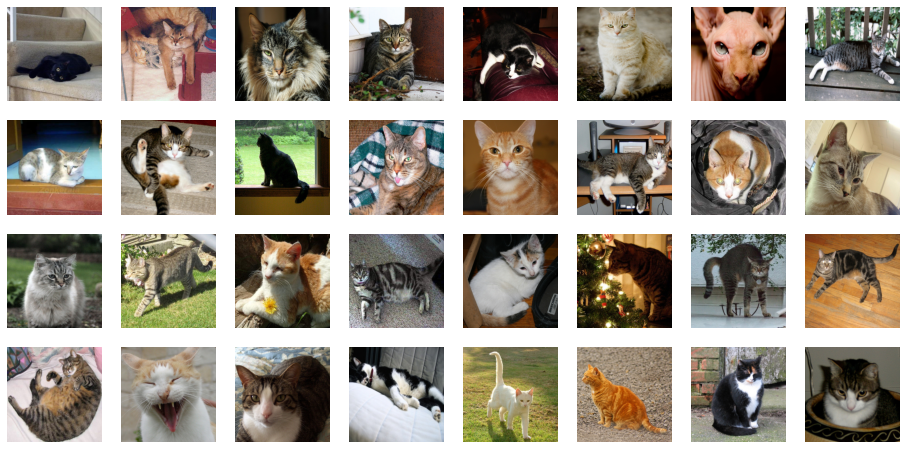

In [111]:
# example of above

fig = plt.figure(figsize=(16,8),frameon=False)
for i,path in enumerate(K_responses[K_responses.category == 'cat'].img_id.unique()):
    request.urlretrieve(path,'temp.png')
    img = Image.open("temp.png")
    p = plt.subplot(4,8,i+1)
    plt.imshow(img)
    k = p.get_xaxis().set_ticklabels([])
    k = p.get_yaxis().set_ticklabels([])
    k = p.get_xaxis().set_ticks([])
    k = p.get_yaxis().set_ticks([])
    p.axis('off')

In [64]:
## get list of object paths
categories = K_responses[K_responses.catch_trial == False].category.unique()
cat_paths = [os.path.join(typ_stims_dir,cat) for cat in categories]

In [ ]:

fig = plt.figure(figsize=(8,16),frameon=False)
for i,f in enumerate(close_paths):
    im = Image.open(f)
    p = plt.subplot(8,4,i+1)
    plt.imshow(im)
    k = p.get_xaxis().set_ticklabels([])
    k = p.get_yaxis().set_ticklabels([])
    k = p.get_xaxis().set_ticks([])
    k = p.get_yaxis().set_ticks([])
    p.axis('off')

### Sandbox

In [ ]:
stop!

In [ ]:
K_responses_batch0 = coll.find({'iterationName':iterationName, 
            'prolificID': {'$exists' : True, '$nin' : ['5f6d4203b5f3c71c3d5ec60f']},
            'studyID': {'$exists' : True},
            'sessionID': {'$exists' : True},
            'eventType': 'rating-task'
})
K_responses_batch0 = pd.DataFrame(K_responses_batch0)
K_responses_batch0 = K_responses_batch0[K_responses_batch0.batch_num == 0]

K_flags_batch0 = coll.find({'prolificID': {'$exists' : True, '$nin' : ['5f6d4203b5f3c71c3d5ec60f', None]},
            'studyID': {'$exists' : True},
            'sessionID': {'$exists' : True},
            'eventType': 'trial-catches',
            'batch_num': {'$exists': False}
})
K_flags_batch0 = pd.DataFrame(K_flags_batch0)

# manually check if these are the right participants
a = ['5e8f7954d8c35926fb501f63', '5f7f8e2dfb4b2614748ffd3d', '5bc461db0b03740001230617', '5f3f2ef63ab8fa227e630d26', 
'5e1c9ecfcd8c4e01296e052d', '5f723cf881f5c0159cfa6da1', '5ba863a346de410001ecfb2a', '5f7fc54f6566cd19895017ea',
'5f7fb2676397a318ad5688fd', '5f7fc36718e5dc19dc1058ca'].sort() 
b = list(K_flags_batch0.prolificID.values).sort() 

# assign batch num 
K_flags_batch0 = K_flags_batch0.assign(batch_num = 0)

# make map from prolificID to flags and use map to extend to K_responses
id_to_flags = dict(zip(K_flags_batch0['prolificID'].values, K_flags_batch0[['failed_catches', 'num_failed','lazy_responder','repeat_offender']].values.tolist()))

df1 = K_responses_batch0['prolificID'].map(id_to_flags)
df1 = pd.DataFrame(df1.tolist(), df1.index, columns = ['failed_catches', 'num_failed','lazy_responder','repeat_offender'])

K_responses_batch0 = pd.concat([K_responses_batch0, df1], axis=1)
a == b

In [ ]:
# reformat the response data to only include values from ['Very Poor', ..., 'Very Well']
value_list = []
for dic in K_responses_batch0.responses.values:
    value_list.append(json.loads(dic)['typicality'])
K_responses_batch0 = K_responses_batch0.assign(ratings = value_list)


# drop unneccesary columns and drop empty ratings
K_responses_batch0 = K_responses_batch0.drop(columns=['devMode', 'preamble', 'required', 'questions', 
                            'randomize_question_order', 'scale_width', 'button_label', 'responses',
                            'question_order', 'trial_type', 'internal_node_id'])
K_responses_batch0['ratings'] = K_responses_batch0['ratings'].replace('', np.nan)
K_responses_batch0 = K_responses_batch0.dropna(subset=['ratings'])

di = {"Not At All": -2, "Somewhat": -1, "Moderately": 0, "Very": 1, "Extremely": 2}
K_responses_batch0['enumerated_ratings'] = K_responses_batch0['ratings'].map(lambda x: di[x])

# merge catch trials and main trials
K_responses_batch0 = K_responses_batch0.sort_values('img_id')
K_responses_batch0['img_id'] = K_responses_batch0['img_id'].fillna(K_responses_batch0['img_url'])
K_responses_batch0 = K_responses_batch0.reset_index(drop=True).drop(columns=['img_url'])

In [ ]:
ad2f = K_responses_batch0[K_responses_batch0.prolificID == '5bc461db0b03740001230617']
dup_indices = ad2f.loc[ad2f.duplicated(subset='img_id', keep=False)].index
duplicates = K_responses_batch0.iloc[dup_indices].reset_index(drop=True)
np_duplicates = np.reshape(duplicates['enumerated_ratings'].values, (-1, 2))

In [ ]:
# identical response
print(sum([i[0] == i[1] for i in np_duplicates]))

# 1 off from identical response
print(sum([i[0] in range(i[1] - 1, i[1] + 2) for i in np_duplicates]))

In [ ]:
# fix duplicate indices from that one participant
adf = K_responses_batch0[K_responses_batch0.prolificID == '5bc461db0b03740001230617']
dup_indices = adf.loc[adf.duplicated(subset='img_id', keep='last')].index
K_responses_batch0 = K_responses_batch0.drop(dup_indices).reset_index(drop=True)

<br><br>
#### How many people are picking the same rating per image?

In [ ]:
arr = []
arr2 = []
for img in np.delete(K_responses_batch0.img_id.unique(), 17):    # there is a random nan value at index 17
    tmpa = K_responses_batch0[(K_responses_batch0.img_id == img) & (K_responses_batch0.failed_catches == True)]
    tmpb = K_responses_batch0[(K_responses_batch0.img_id == img) & (K_responses_batch0.failed_catches == False)]
    tmpc = mode(K_responses_batch0[K_responses_batch0.img_id == img]['enumerated_ratings'])[0][0]
    a = mode(tmpa['enumerated_ratings'])[1][0]/5   # 5 people failed, 5 people did not
    b = mode(tmpb['enumerated_ratings'])[1][0]/5
    a2 = tmpa[tmpa.enumerated_ratings == tmpc]['enumerated_ratings'].count()/5
    b2 = tmpb[tmpb.enumerated_ratings == tmpc]['enumerated_ratings'].count()/5
    arr.append([a,b])
    arr2.append([a2,b2])
arr = np.asarray(arr)
arr2 = np.asarray(arr2)

In [ ]:
# what proportion of participants picked the modal response for each image?
sns.distplot(arr[:,0], hist=False, rug=True, label='failed')
sns.distplot(arr[:,1], hist=False, rug=True, label='did not fail');
plt.xlabel('proportion of participants who shared the same response in a given image');
plt.title('mode calculated separately for for each image');

In [ ]:
sns.distplot(arr2[:,0], hist=False, rug=True, label='failed')
sns.distplot(arr2[:,1], hist=False, rug=True, label='did not fail');
plt.xlabel('proportion of participants who shared the same response in a given image');
plt.title('combined mode between both types for each image');

In [ ]:
sns.distplot(K_responses_batch0[K_responses_batch0.failed_catches == True]['enumerated_ratings'], label='failed');
sns.distplot(K_responses_batch0[K_responses_batch0.failed_catches == False]['enumerated_ratings'], label='did not fail')
plt.legend();
plt.title('distribution of ratings between those who failed catch trials and those who did not');

#### How similar are different participants' responses?

In [ ]:
import random
import statistics
from itertools import combinations

In [ ]:
# compressed form: sims = [sum([ratings[i,k] == ratings[j,k] for k in range(ratings.shape[1])]) for i,j in combinations(range(10), 2)]

def get_pairwise_similarity_matrix(ratings, distance = 0):
    '''
        ratings: a # participants x # images 2D numpy array
        returns an upper triangular matrix that compares rating responses for participant i and participant j 
    '''
    sims = []
    # for each pair of participants,
    for i,j in combinations(range(ratings.shape[0]), 2):
        tmp = 0
        # for each image,
        for k in range(ratings.shape[1]):
            # is participant j's rating 'distance' away from participant i's rating? 
            if distance != 0:
                tmp += ratings[j,k] in range(ratings[i,k] - distance, ratings[i,k] + distance + 1) # +1 for inclusive upper bound
            else:
                tmp += ratings[j,k] == ratings[i,k]
        sims.append(tmp)
    
    # turn it into upper triangular matrix
    tri = np.zeros((ratings.shape[0], ratings.shape[0]))
    tri[np.triu_indices(ratings.shape[0], 1)] = sims
    
    return tri/ratings.shape[1]

In [ ]:
print(K_responses_batch0[K_responses_batch0.catch_trial == True][['img_id','enumerated_ratings']].sort_values('img_id').values)

#.groupby('img_id')['enumerated_ratings'].mean()

what specific images are the people who pass the catch trials missing?

In [ ]:
# generate a dictionary with key: prolificID, value: subset of K_responses_batch0 corresponding to that prolificID
a = {k: v for (k, v) in K_responses_batch0.groupby('prolificID')}
keys = list(a.keys())

# get just the enumerated ratings in the form of a 2D numpy array
participant_ratings = np.stack([a[i].enumerated_ratings.values for i in keys], axis=0)
print('shape:', participant_ratings.shape)

# get average correlation across all pairs of participants
participant_ratings_noatypical = np.delete(participant_ratings, 2, 0)
corrs = [np.corrcoef(participant_ratings_noatypical[i], participant_ratings_noatypical[j])[0,1] for i,j in combinations(range(9), 2)]
a = np.asarray(corrs)
print('average pairwise correlation across all participants, removing atypical one', a.mean())

In [ ]:
# set up pass vs failed catch trials
K_pass = K_responses_batch0[(K_responses_batch0.failed_catches == False) & (K_responses_batch0.prolificID != '5e1c9ecfcd8c4e01296e052d')]
K_fail = K_responses_batch0[(K_responses_batch0.failed_catches == True)  & (K_responses_batch0.prolificID != '5e1c9ecfcd8c4e01296e052d')]

# generate a dictionary with key: prolificID, value: subset of K_responses_batch0 corresponding to that prolificID
a = {k: v for (k, v) in K_pass.groupby('prolificID')}
keys = list(a.keys())
# get just the enumerated ratings in the form of a 2D numpy array 
participant_ratings_pass_noatypical = np.stack([a[i].enumerated_ratings.values for i in keys], axis=0)

# generate a dictionary with key: prolificID, value: subset of K_responses_batch0 corresponding to that prolificID
a = {k: v for (k, v) in K_fail.groupby('prolificID')}
keys = list(a.keys())
# get just the enumerated ratings in the form of a 2D numpy array
participant_ratings_fail_noatypical = np.stack([a[i].enumerated_ratings.values for i in keys], axis=0)
print("passing vs failed participant responses shape:",participant_ratings_pass_noatypical.shape, participant_ratings_fail_noatypical.shape)

# compute average correlation for set who passed catch trials
corrs = [np.corrcoef(participant_ratings_pass_noatypical[i], participant_ratings_pass_noatypical[j])[0,1] for i,j in combinations(range(participant_ratings_pass_noatypical.shape[0]), 2)]
pass_corr = np.asarray(corrs)
print('participants who passed catch trials, for all trials:', pass_corr.mean())

# compute average correlation for set who failed catch trials
corrs = [np.corrcoef(participant_ratings_fail_noatypical[i], participant_ratings_fail_noatypical[j])[0,1] for i,j in combinations(range(participant_ratings_fail_noatypical.shape[0]), 2)]
fail_corr = np.asarray(corrs)
print('participants who failed catch trials, for all trials:', fail_corr.mean())

-- try between pass and fail, are their response vectors systematically different

In [ ]:
# set up isCatchTrial x failedCatches 2x2 
K_catch = K_responses_batch0[(K_responses_batch0.catch_trial == True) & (K_responses_batch0.prolificID != '5e1c9ecfcd8c4e01296e052d')]
K_main = K_responses_batch0[(K_responses_batch0.catch_trial == False) & (K_responses_batch0.prolificID != '5e1c9ecfcd8c4e01296e052d')]

K_catch_pass = K_catch[K_catch.failed_catches == False]
K_catch_fail = K_catch[K_catch.failed_catches == True]
K_main_pass = K_main[K_main.failed_catches == False]
K_main_fail = K_main[K_main.failed_catches == True]
print('dataframe shapes:', K_catch_pass.shape, K_catch_fail.shape, K_main_pass.shape, K_main_fail.shape)

# extract ratings only as 2D numpy array for 2x2 set
a = {k: v for (k, v) in K_catch_pass.groupby('prolificID')}
keys = list(a.keys())
participant_ratings_catch_pass = np.stack([a[i].enumerated_ratings.values for i in keys], axis=0)

a = {k: v for (k, v) in K_catch_fail.groupby('prolificID')}
keys = list(a.keys())
participant_ratings_catch_fail = np.stack([a[i].enumerated_ratings.values for i in keys], axis=0)

a = {k: v for (k, v) in K_main_pass.groupby('prolificID')}
keys = list(a.keys())
participant_ratings_main_pass = np.stack([a[i].enumerated_ratings.values for i in keys], axis=0)

a = {k: v for (k, v) in K_main_fail.groupby('prolificID')}
keys = list(a.keys())
participant_ratings_main_fail = np.stack([a[i].enumerated_ratings.values for i in keys], axis=0)

print('2D numpy shapes', participant_ratings_catch_pass.shape, participant_ratings_catch_fail.shape, participant_ratings_main_pass.shape, participant_ratings_main_fail.shape)

# get average correlation for for the 2x2 set
corrs = [np.corrcoef(participant_ratings_catch_pass[i], participant_ratings_catch_pass[j])[0,1] for i,j in combinations(range(participant_ratings_catch_pass.shape[0]), 2)]
catch_pass_corr = np.asarray(corrs)
print('catch trials only, passing participants:', catch_pass_corr.mean())

corrs = [np.corrcoef(participant_ratings_catch_fail[i], participant_ratings_catch_fail[j])[0,1] for i,j in combinations(range(participant_ratings_catch_fail.shape[0]), 2)]
catch_fail_corr = np.asarray(corrs)
print('catch trials only, failing participants:', catch_fail_corr.mean())

corrs = [np.corrcoef(participant_ratings_main_pass[i], participant_ratings_main_pass[j])[0,1] for i,j in combinations(range(participant_ratings_main_pass.shape[0]), 2)]
main_pass_corr = np.asarray(corrs)
print('no catch trials, passing participants:', main_pass_corr.mean())

corrs = [np.corrcoef(participant_ratings_main_fail[i], participant_ratings_main_fail[j])[0,1] for i,j in combinations(range(participant_ratings_main_fail.shape[0]), 2)]
main_fail_corr = np.asarray(corrs)
print('no catch trials, failing participants:', main_fail_corr.mean())

In [ ]:
# generate a dictionary with key: prolificID, value: subset of K_responses_batch0 corresponding to that prolificID
b = {k: v for (k, v) in K_responses_batch0[K_responses_batch0.failed_catches == True].groupby('prolificID')}
keys = list(b.keys())

# get just the enumerated ratings in the form of a 2D numpy array
list_ = []
for i in keys:
    list_.append(b[i].enumerated_ratings.values)
participant_ratings_failed = np.stack(list_, axis=0)

# generate a dictionary with key: prolificID, value: subset of K_responses_batch0 corresponding to that prolificID
c = {k: v for (k, v) in K_responses_batch0[K_responses_batch0.failed_catches == False].groupby('prolificID')}
keys = list(c.keys())

# get just the enumerated ratings in the form of a 2D numpy array
list_ = []
for i in keys:
    list_.append(c[i].enumerated_ratings.values)
participant_ratings_passed = np.stack(list_, axis=0)
participant_ratings_failed.shape, participant_ratings_passed.shape

In [ ]:
# simulate the expected standard deviation of 10 people guessing at random
print('chance std. dev (passed):', statistics.mean([statistics.pstdev(random.choices([-2,-1,0,1,2], k=4)) for i in range(10000)]))
# get the mean standard deviation of ratings within each image, where the range of standard deviations possible is [0,2]
print('actual std. dev (passed):', statistics.mean([participant_ratings_passed[:, i].std() for i in range(136)]))

In [ ]:
# simulate the expected standard deviation of 10 people guessing at random
print('chance std. dev (failed):', statistics.mean([statistics.pstdev(random.choices([-2,-1,0,1,2], k=6)) for i in range(10000)]))
# get the mean standard deviation of ratings within each image, where the range of standard deviations possible is [0,2]
print('actual std. dev (failed):', statistics.mean([participant_ratings_failed[:, i].std() for i in range(136)]))

In [ ]:
# simulate the expected standard deviation of 10 people guessing at random
print('chance std. dev:', statistics.mean([statistics.pstdev(random.choices([-2,-1,0,1,2], k=10)) for i in range(10000)]))

# get the mean standard deviation of ratings within each image, where the range of standard deviations possible is [0,2]
print('actual std. dev:', statistics.mean([participant_ratings[:, i].std() for i in range(136)]))

In [ ]:
# get the number of identical responses for all combinations of participants
sims = get_pairwise_similarity_matrix(participant_ratings_passed, 0)

# plot results
sns.heatmap(sims, vmax = 0.5)
plt.xlabel('participant index')
plt.ylabel('participant index')
plt.title('proportion of identical responses between two participants (passed)');

In [ ]:
# get the number of identical responses for all combinations of participants
sims = get_pairwise_similarity_matrix(participant_ratings_failed, 0)

# plot results
sns.heatmap(sims, vmax = 0.5)
plt.xlabel('participant index')
plt.ylabel('participant index')
plt.title('proportion of identical responses between two participants (failed)');

In [ ]:
# get the number of identical responses for all combinations of participants
sims = get_pairwise_similarity_matrix(participant_ratings, 0)

# plot results
sns.heatmap(sims)
plt.xlabel('participant index')
plt.ylabel('participant index')
plt.title('proportion of identical responses between two participants');

In [ ]:
22/60
sims[sims != 0].mean()

In [ ]:
# get the number of identical responses for all combinations of participants
sims = get_pairwise_similarity_matrix(participant_ratings, 1)

# plot results
sns.heatmap(sims)
plt.xlabel('participant index')
plt.ylabel('participant index')
plt.title('proportion of responses off by 1 between two participants');

In [ ]:
49/60, sims[sims != 0].mean()

In [ ]:
# get the number of identical responses for all combinations of participants
sims = get_pairwise_similarity_matrix(participant_ratings, 2)

# plot results
sns.heatmap(sims)
plt.xlabel('participant index')
plt.ylabel('participant index')
plt.title('proportion of responses off by 2 between two participants');

In [ ]:
# get the number of identical responses for all combinations of participants
sims = get_pairwise_similarity_matrix(participant_ratings, 3)

# plot results
sns.heatmap(sims)
plt.xlabel('participant index')
plt.ylabel('participant index')
plt.title('proportion of responses off by 3 between two participants');

In [ ]:
# get the number of identical responses for all combinations of participants
sims = get_pairwise_similarity_matrix(participant_ratings, 4)

# plot results
sns.heatmap(sims)
plt.xlabel('participant index')
plt.ylabel('participant index')
plt.title('proportion of responses off by 4 between two participants');

Kappa statistics

In [ ]:
from statsmodels.stats.inter_rater import fleiss_kappa
from nltk import agreement

In [ ]:
formatted_codes = [[index, index2, rating] for index, ppt in enumerate(participant_ratings.tolist()) for index2, rating in enumerate(ppt)]
formatted_codes_passed = [[index, index2, rating] for index, ppt in enumerate(participant_ratings_passed.tolist()) for index2, rating in enumerate(ppt)]
formatted_codes_failed = [[index, index2, rating] for index, ppt in enumerate(participant_ratings_failed.tolist()) for index2, rating in enumerate(ppt)]


len(formatted_codes), len(formatted_codes_passed), len(formatted_codes_failed)

These are some pretty low scores! <br><br><br><br>

### Let's look for a rejection criteria for counteracting people who guess/select one thing

In [ ]:
from scipy.stats import chisquare

In [ ]:
#sum(ind_count)
#[i*sum(ind_count) for i in pop_prop]

In [ ]:
res = {}
for mini in K_responses.batch_num.unique():
    miniset = K_responses[K_responses.batch_num == mini]
    for ppt in miniset.prolificID.unique():
        pop = miniset[miniset.prolificID != ppt].ratings.values
        ind = miniset[miniset.prolificID == ppt].ratings.values

        frequency_pop, frequency_ind = {}, {}
        for item in np.unique(pop).tolist():
            frequency_pop[item] = pop.tolist().count(item)
            frequency_ind[item] = ind.tolist().count(item)
        ind_count = list(frequency_ind.values())
        pop_count = list(frequency_pop.values())
        pop_prop = [i/sum(pop_count) for i in pop_count]

        expected_adj = [i*sum(ind_count) for i in pop_prop]

        res[ppt] = chisquare(f_obs=ind_count, f_exp=expected_adj)[0:2]
[i[1] for i in list(res.values())]
sum([i[1]<0.01 for i in list(res.values())])

In [ ]:
res = {}
for ppt in K_responses.prolificID.unique():
    pop = K_responses[K_responses.prolificID != ppt].ratings.values
    ind = K_responses[K_responses.prolificID == ppt].ratings.values
    
    frequency_pop, frequency_ind = {}, {}
    for item in np.unique(pop).tolist():
        frequency_pop[item] = pop.tolist().count(item)
        frequency_ind[item] = ind.tolist().count(item)
    ind_count = list(frequency_ind.values())
    pop_count = list(frequency_pop.values())
    pop_prop = [i/sum(pop_count) for i in pop_count]
    
    expected_adj = [i*sum(ind_count) for i in pop_prop]
    
    res[ppt] = chisquare(f_obs=ind_count, f_exp=expected_adj)[0:2]
sum([i[1]<0.01 for i in list(res.values())])

In [ ]:
from math import floor, ceil

In [ ]:
from collections import defaultdict
myList = defaultdict(list)
[myList[key] for key in K_responses.prolificID.unique()]
myList

In [ ]:
ppt_vals = dict([(i,[]) for i in K_responses.prolificID.unique().tolist()])

for img in K_responses.img_id.unique():
    imgset = K_responses[K_responses.img_id == img]
    for ppt in imgset.prolificID.unique():
        ind_rating = imgset[imgset.prolificID == ppt].enumerated_ratings.values[0]

        # for this specific image, is this participant's response near the mean response?
        mean_ratings = imgset.enumerated_ratings.mean()
        ppt_vals[ppt].append(floor(mean_ratings) <= ind_rating 
                             <= ceil(mean_ratings))

sns.distplot([sum(ppt_vals[i]) for i in ppt_vals.keys()]);

In [ ]:
from scipy.stats import mode

In [ ]:
ppt_vals = dict([(i,[]) for i in K_responses.prolificID.unique().tolist()])

for img in K_responses.img_id.unique():
    imgset = K_responses[K_responses.img_id == img]
    for ppt in imgset.prolificID.unique():
        ind_rating = imgset[imgset.prolificID == ppt].enumerated_ratings.values[0]
        
        # for this specific image, is this participant's response the modal response?
        ppt_vals[ppt].append(mode(imgset.enumerated_ratings.values)[0][0] == ind_rating)

sns.distplot([sum(ppt_vals[i]) for i in ppt_vals.keys()])
[sum(ppt_vals[i]) for i in ppt_vals.keys()]

In [ ]:
np.histogram([sum(ppt_vals[i]) for i in ppt_vals.keys()])
plt.hist([sum(ppt_vals[i]) for i in ppt_vals.keys()])

In [ ]:
ppt_vals = dict([(i,[]) for i in K_responses.prolificID.unique().tolist()])

for img in K_responses.img_id.unique():
    imgset = K_responses[K_responses.img_id == img]
    for ppt in imgset.prolificID.unique():
        ind_rating = imgset[imgset.prolificID == ppt].enumerated_ratings.values[0]
        
        # for this specific image, is this participant's response the modal response? Scaled by agreement
        [ppt_vals[ppt].append(mode(imgset.enumerated_ratings.values)[0][0] == ind_rating) for i in range(mode(imgset.enumerated_ratings.values)[1][0])]

sns.distplot([sum(ppt_vals[i]) for i in ppt_vals.keys()])

In [ ]:
plt.hist([sum(ppt_vals[i]) for i in ppt_vals.keys()])

In [ ]:
th = np.asarray([[i, sum(ppt_vals[i])] for i in ppt_vals.keys()])
th = th[th[:,0].argsort()][:,1]

In [ ]:
# generate a dictionary with key: prolificID, value: subset of K_responses corresponding to that prolificID
b = {k: v for (k, v) in K_responses.groupby('prolificID')}
keys = list(b.keys())

# get just the enumerated ratings in the form of a 2D numpy array
list_ = []
for i in keys:
    list_.append(b[i].enumerated_ratings.values)
participant_ratings = np.stack(list_, axis=0)



In [ ]:
# get the number of identical responses for all combinations of participants
sims = get_pairwise_similarity_matrix(participant_ratings, 0)
mask = np.zeros_like(sims)
mask[np.tril_indices_from(mask)] = True


# plot results
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(sims, square=True, ax=ax,mask=mask,  cbar_kws={"shrink": .5}, rasterized=False)
ax.set_xticklabels(th, rotation=90)
ax.set_yticklabels(th)

# ax2 = fig.add_subplot(111, label="secondary")
# ax2.set_aspect("equal")
# ax2.set_xlim(ax.get_xlim())
# ax2.set_ylim(ax.get_ylim())
# ax2.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False,
#                 top=True, labeltop=True)
# ax2.set_facecolor("none")
# for _, spine in ax2.spines.items():
#     spine.set_visible(False)
# ax2.set_xticks(ax.get_xticks())
# ax2.set_xticklabels(keys, fontsize=13)
# plt.setp(ax2.get_xticklabels(), rotation=45, ha="left",
#          rotation_mode="anchor")


plt.xlabel('# of modal responses for this participant')
plt.ylabel('# of modal responses for this participant')
plt.title('number of identical responses between two participants');
fig.tight_layout()


In [ ]:
smh = np.asarray([np.append(sims[i, :], sims[:,i])[np.append(sims[i, :], sims[:,i]) != 0] for i in range(len(sims))])
x,y = smh.mean(axis=1), th.astype(np.int)/136
plt.plot(x, y, '.')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)
plt.xlabel('average proportion of identical responses')
plt.ylabel('proportion of modal ratings');


In [ ]:
sns.countplot(K_responses[K_responses.prolificID == '5def907bd6c08d000a157a88']['enumerated_ratings'])

In [ ]:
plt.hist(euc_ratings.mean().values)
plt.xlabel('mean euclidean distance')
plt.ylabel('frequency')
plt.title('distribution of euclidean distances for each participant');

In [ ]:
plt.hist(cos_ratings.mean().values)
plt.xlabel('mean cosine distance')
plt.ylabel('frequency')
plt.title('distribution of cosine distances for each participant');

In [ ]:
plt.hist(corr_ratings.mean().values)
plt.xlabel('mean correlation coefficient')
plt.ylabel('frequency')
plt.title('distribution of mean correlations for each participant');

In [ ]:
plt.hist(euc_ratings.mean().values)
plt.xlabel('mean euclidean distance')
plt.ylabel('frequency')
plt.title('distribution of euclidean distances for each participant');

In [ ]:
plt.hist(cos_ratings.mean().values)
plt.xlabel('mean cosine distance')
plt.ylabel('frequency')
plt.title('distribution of cosine distances for each participant');

In [ ]:
plt.hist(corr_ratings.mean().values)
plt.xlabel('mean correlation coefficient')
plt.ylabel('frequency')
plt.title('distribution of mean correlations for each participant');

In [ ]:
plt.hist(K_responses[K_responses.prolificID == '5def907bd6c08d000a157a88'].enumerated_ratings.values);

In [ ]:
plt.hist(K_responses[K_responses.prolificID == '5f6b0d716f590a1ea96a2c42'].enumerated_ratings.values);

In [ ]:
plt.hist(K_responses[K_responses.prolificID == '5eb7ace91de6e86e9a6053d2'].enumerated_ratings.values);

In [ ]:
K_responses.groupby('prolificID')['enumerated_ratings'].mean()

In [ ]:
response_freqs[1]/response_freqs[1].sum(),response_freqs[0]

In [ ]:
np.random.choice(list(response_freqs.keys()), size=136, p=list(response_freqs.values()))

In [ ]:
# simulation of our trial according to current response frequencies 
from itertools import groupby
import heapq

response_freqs = np.unique(K_responses.enumerated_ratings.values, return_counts=True)
response_freqs = dict(zip(response_freqs[0],response_freqs[1]/response_freqs[1].sum()))

def generate_consecutives():
    randresps = np.random.choice(list(response_freqs.keys()), size=136, p=list(response_freqs.values()))
    return heapq.nlargest(2, (len(list(y)) for (c,y) in groupby(randresps)))

arr = np.asarray([generate_consecutives() for i in range(10000)])
sum((arr[:,0] >= 20) | ((arr[:,0] >= 10) & (arr[:,1] >= 10)))

In [ ]:
sum((arr[:,0] >= 10))

In [ ]:
K_flags.lazy_responder.sum()

In [ ]:
grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(randresps)]


In [ ]:
corr_ratings.mean()

<br><br><br><br>

### Sandbox

In [ ]:
stop!

For the first pilot of 10 participants on prolific, they were recorded in the iterationName 'development'

With 136 trials and 2 exit survey trials, there will be up to 10 * (136 + 2) = 1380 trials

The code to extract information from those participants follows below:

In [ ]:
k_pilot = coll.find({'iterationName':'development', 
                     'prolificID': {'$exists' : True, '$nin' : ['5f6d4203b5f3c71c3d5ec60f', None]},
                     'studyID': {'$exists' : True},
                     'sessionID': {'$exists' : True}})
K_pilot = pd.DataFrame(k_pilot)
K_pilot.shape

note: there are 1379 entries because one participant did not fill in the survey-text trial

In [ ]:
# separate into response trials and exit survey trials
K_responses_pilot = K_pilot[K_pilot['eventType'] == 'rating-task']
K_survey_pilot = K_pilot[K_pilot['eventType'] == 'survey']

K_responses = pd.DataFrame()
K_survey = pd.DataFrame()
K_flags = K[~pd.isna(K['num_failed'])]

K_responses = K_responses.append(K_responses_pilot)
K_survey = K_survey.append(K_survey_pilot)

In [ ]:
# reformat the response data to only include values from ['Very Poor', ..., 'Very Well']
value_list = []
for dic in K_responses.responses.values:
    value_list.append(json.loads(dic)['typicality'])
K_responses = K_responses.assign(ratings = value_list)

# drop unneccesary columns and drop empty ratings
K_responses = K_responses.drop(columns=['devMode', 'preamble', 'required', 'questions', 
                            'randomize_question_order', 'scale_width', 'button_label', 'responses',
                            'question_order', 'trial_type', 'internal_node_id'])
K_responses['ratings'] = K_responses['ratings'].replace('', np.nan)
K_responses = K_responses.dropna(subset=['ratings'])

di = {"Not At All": -2, "Somewhat": -1, "Moderately": 0, "Very": 1, "Extremely": 2}
K_responses['enumerated_ratings'] = K_responses['ratings'].map(lambda x: di[x])

In [ ]:
plt.figure(figsize=(8,4))
order = ["Not At All", "Somewhat", "Moderately", "Very", "Extremely"]
sns.countplot(K_responses['ratings'], palette='viridis', order=order);
plt.xlabel('typicality rating');
plt.title('counts of typicality ratings for current complete trials');

In [ ]:
g = sns.FacetGrid(K_responses, col='prolificID', col_wrap=2, aspect=2)
g.map(sns.countplot, "ratings", order=order, palette='viridis');

In [ ]:
g = sns.FacetGrid(K_responses, col='category', col_wrap=5, aspect=2)
g.map(sns.countplot, "ratings", order=order, palette='viridis')